## Подготовка

In [1]:
# Библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('F:\D\Start\Data scientist 2.0\Projects\Progect_Timelines/taxi.csv', index_col=[0], parse_dates=[0])
#df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [3]:
print(df.head(5))
print(df.tail(5))
df.info()

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
                     num_orders
datetime                       
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# Ресемплинг 1 час

df = df['2018-03' : '2018-05'].resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

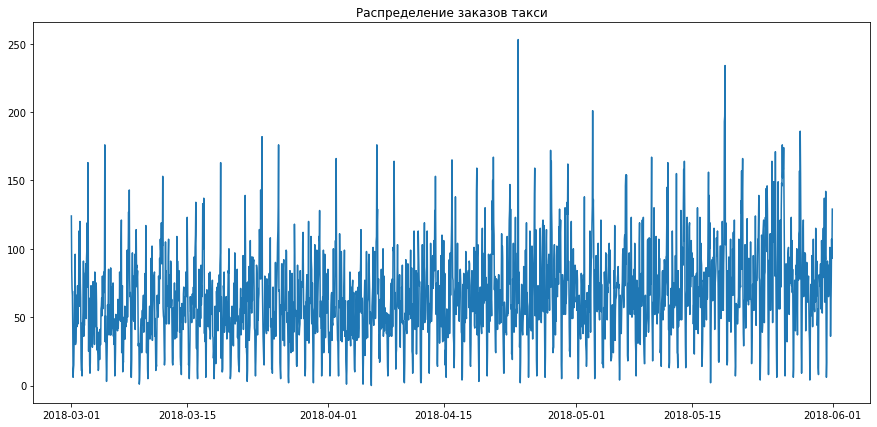

In [5]:
# Посмотрим динамику изменения количества заказов на графике.

plt.figure(figsize = (15, 7))

plt.plot(df.index, df['num_orders'])

plt.title('Распределение заказов такси')

plt.show()

Таким образом сложно разобраться. Разобьем данные на 3 месяца, для наглядности.

In [6]:
df_may = df['2018-05' : '2018-06']
df_april = df['2018-04' : '2018-05']
df_march = df['2018-03' : '2018-04']
df_may.head()

,num_orders
datetime,
2018-05-01 00:00:00,81
2018-05-01 01:00:00,74
2018-05-01 02:00:00,55
2018-05-01 03:00:00,84
2018-05-01 04:00:00,77


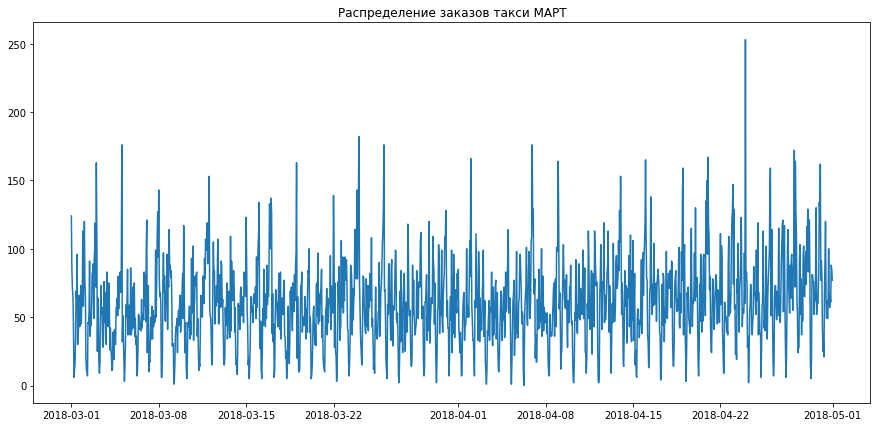

In [7]:
plt.figure(figsize = (15, 7))
plt.plot(df_march.index, df_march['num_orders'])
plt.title('Распределение заказов такси МАРТ')
plt.show()

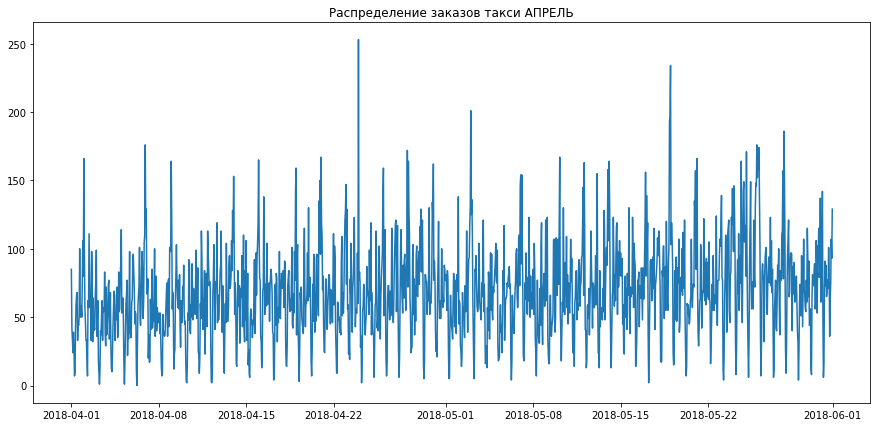

In [8]:
plt.figure(figsize = (15, 7))
plt.plot(df_april.index, df_april['num_orders'])
plt.title('Распределение заказов такси АПРЕЛЬ')
plt.show()

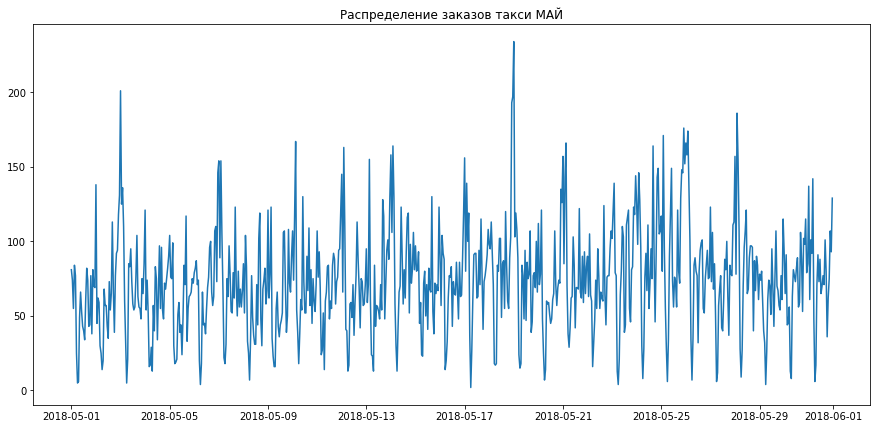

In [9]:
plt.figure(figsize = (15, 7))
plt.plot(df_may.index, df_may['num_orders'])
plt.title('Распределение заказов такси МАЙ')
plt.show()

Графики очень похожи. Посмотрим на пики.

In [10]:
df.sort_values(by = ['num_orders'], ascending=False).head(10)

,num_orders
datetime,
2018-04-24 00:00:00,253
2018-05-19 00:00:00,234
2018-05-03 00:00:00,201
2018-05-18 23:00:00,197
2018-05-18 22:00:00,193
2018-05-28 02:00:00,186
2018-03-24 01:00:00,182
2018-05-25 22:00:00,176
2018-03-05 01:00:00,176


Пики приходятся на позднее время, когда общественный транспорт либо плохо ходит, либо совсем отправился спать. Что ж, это логично.

Посмотрим на тренды и сезонность.

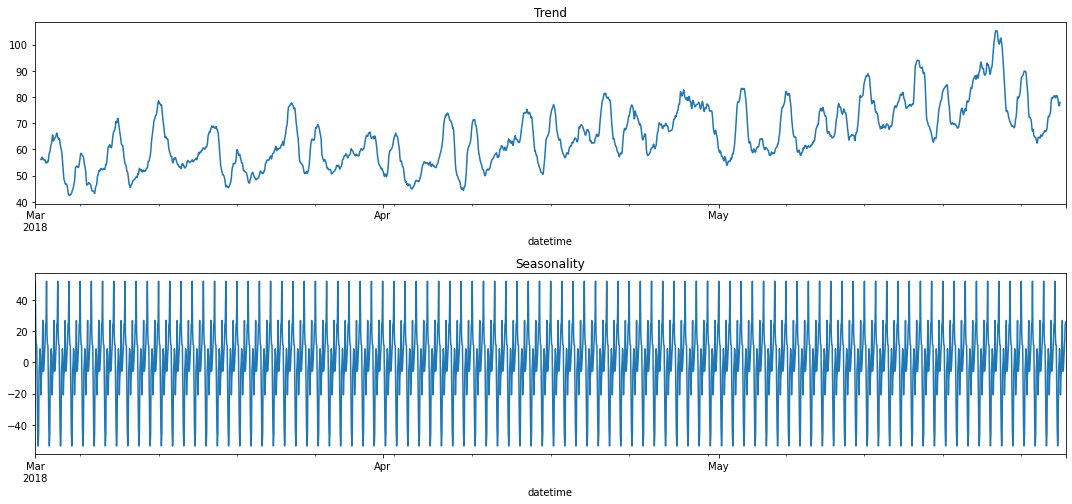

In [11]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.tight_layout()

Похоже, что есть тренд на увеличение заказов. Не зря в пиках чаще всего попадается май. Люди стали чаще пользоваться такси. Или весь май была плохая погода :)

## Обучение

In [12]:
# Разделение на выборки

train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [13]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-05-22 18:00:00
2018-05-22 19:00:00 2018-05-31 23:00:00


In [14]:
# Функция для RMSE

def rmse(test, predictions):
    return mse(test, predictions)**0.5

### Модель предыдущего значения

In [15]:
predictions_prev = test.shift()
predictions_prev.iloc[0] = train.iloc[-1]
rmse_prev = rmse(test['num_orders'], predictions_prev)
print(rmse_prev)

34.62213609372344


Забавно, но на этом можно и закончить. Значение метрики качества 35, когда заданный порог 48.

Но мы ведь на этом не остановимся, правда? Теперь у нас есть ещё один ориентир.

### Создание принзнаков для моделей

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(df, 2, 24)
df.head(5)

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN


In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train.dropna(inplace=True)

In [19]:
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)

target_train = train['num_orders']
target_test = test['num_orders']

### Линейная регрессия

In [20]:
model_reg = LinearRegression()
model_reg.fit(features_train, target_train)
predictions_train_reg = model_reg.predict(features_train)
rmse_train_reg = rmse(target_train, predictions_train_reg)
rmse_train_reg

27.00730387963708

Линейная регрессия справилась ещё лучше! Посмотрим, что покажется LightGBM.

### LightGBM

In [21]:
model_lgb1 = lgb.LGBMRegressor()
model_lgb1.fit(features_train,target_train)
predictions_train_lgb1 = model_lgb1.predict(features_train)
rmse_train_lgb1 = rmse(target_train, predictions_train_lgb1)
rmse_train_lgb1

12.781641275559426

И без гиперпараметров модель справилась прекрасно. Попробуем ещё ее улучшить.

In [22]:
params = {'n_estimators': range(160, 360, 5), 'max_depth': range(2,17), 'num_leaves': [40, 300, 5]}

In [23]:
tscv = TimeSeriesSplit(n_splits=7)
grid = GridSearchCV(estimator=model_lgb1, param_grid=params, scoring=rmse, n_jobs=-1, cv=tscv, verbose=1)

In [24]:
grid.fit(features_train, target_train)

Fitting 7 folds for each of 1800 candidates, totalling 12600 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 17),
                         'n_estimators': range(160, 360, 5),
                         'num_leaves': [40, 300, 5]},
             scoring=<function rmse at 0x00000262815040D0>, verbose=1)

In [25]:
grid.best_params_

{'max_depth': 2, 'n_estimators': 160, 'num_leaves': 40}

In [26]:
model_lgb2 = lgb.LGBMRegressor(n_estimators = 160, max_depth = 2, num_leaves = 40)
model_lgb2.fit(features_train,target_train)
predictions_train_lgb2 = model_lgb2.predict(features_train)
rmse_train_lgb2 = rmse(target_train, predictions_train_lgb2)
rmse_train_lgb2

18.918341485503834

Любопытно, что lgb без моих гиперпараметров справилась лучше. Посмотрим, что покажут модели на тесте.

## Тестирование

In [27]:
predictions_test_reg = model_reg.predict(features_test)
rmse_test_reg = rmse(target_test, predictions_test_reg)

predictions_test_lgb1 = model_lgb1.predict(features_test)
rmse_test_lgb1 = rmse(target_test, predictions_test_lgb1)

predictions_test_lgb2 = model_lgb2.predict(features_test)
rmse_test_lgb2 = rmse(target_test, predictions_test_lgb2)

display(rmse_test_reg, rmse_test_lgb1, rmse_test_lgb2)

31.121310756850573

25.52307535823533

25.554890620281206

Лучше всех на тесте показала себя lgb модель! Похоже, лучше не лезть в ее работу, так как с подбором параметров вышло только хуже :)

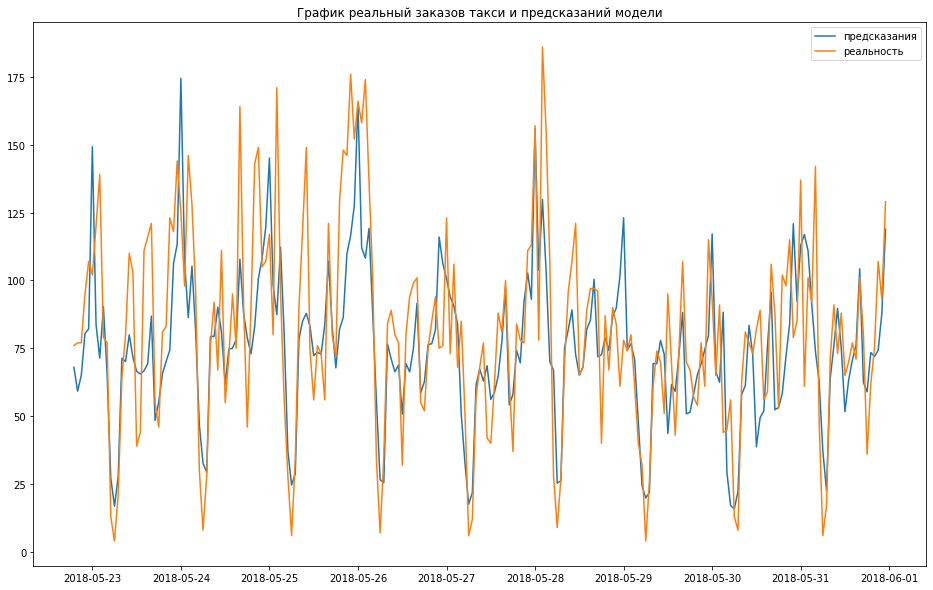

In [28]:
plt.figure(figsize = (16, 10))

plt.plot(target_test.index, predictions_test_lgb1, label='предсказания')
plt.plot(target_test.index, np.array(target_test), label='реальность')

plt.legend()
plt.title('График реальный заказов такси и предсказаний модели')

plt.show()